# Assignment 3 A : Calibration part A (/80pts)

---
Please edit the cell below to include your name and student ID #

**name:** Paul Tran

**SID:** 57931045

NOTE: In this assignment we will build on top of your **project** and **triangulate** functions from previous assignments.  If you weren't happy with your implementation from assignment 2, please consult with the TAs or your classmates to get things cleaned up before starting this assignment.


# 1. Parameterizing 3D Rotations

In order to optimize over the camera rotation during calibration, we need a way to parameterize the space of 3D rotations. There are many different ways to do this and each comes with different tradeoffs, but for our purposes we will adopt a simple approach of building a rotation by a sequence of rotations around the X, Y and Z axes (so called *Tait-Bryan angles*, see https://en.wikipedia.org/wiki/Euler_angles for more discussion)

## 1.1 Implement [15pts]

Write a function **makerotation** which takes as input three angles **rx,ry,rz** and returns a rotation matrix corresponding to rotating by **rx** degrees around the x-axis, followed by a rotation of **ry** degrees around the y-axis, followed by a rotation of **rz** degrees around the z-axis. 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import visutils
%matplotlib inline

In [20]:
def makerotation(rx,ry,rz):
    """
    Generate a rotation matrix    

    Parameters
    ----------
    rx,ry,rz : floats
        Amount to rotate around x, y and z axes in degrees

    Returns
    -------
    R : 2D numpy.array (dtype=float)
        Rotation matrix of shape (3,3)
    """

    rx = np.pi*rx/180.0
    ry = np.pi*ry/180.0
    rz = np.pi*rz/180.0
    Rx = np.array( [[1,0,0],
                     [0,np.cos(rx),-np.sin(rx)],
                     [0,np.sin(rx),np.cos(rx)]])
    Ry = np.array( [[np.cos(ry),0,np.sin(ry)],
                     [0,1,0],
                     [-np.sin(ry),0,np.cos(ry)]])
    Rz = np.array( [[np.cos(rz),-np.sin(rz),0],
                     [np.sin(rz),np.cos(rz),0],
                     [0,0,1]])
    R = (Rz @ Ry @ Rx)
    return R

## 1.2 Testing [5pts]

Work out by hand what a 90 degree rotation should look like around each axis.  Then execute the test examples below and add some tests (asserts) to make sure your code passes. 

Find a way to achieve the same rotation as **makerotation(90,90,0)** but without using rotation around the x-axis.  That is, determine some angles so that **makerotation(0,?,?) == makerotation(90,90,0)**


In [21]:
#
# test your function on some simple examples
#
np.set_printoptions(precision=4,suppress=True)

print(makerotation(90,0,0))

print(makerotation(0,90,0))

print(makerotation(0,0,90))

print(makerotation(90,90,0))

ry = 90
rz = -90
print(makerotation(0,ry,rz))

# figure out what ry,rz values are needed in order to pass this test
assert((makerotation(90,90,0)-makerotation(0,ry,rz)<1e-9).all())

[[ 1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
[[ 0.  0.  1.]
 [ 0.  1.  0.]
 [-1.  0.  0.]]
[[ 0. -1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]]
[[ 0.  1.  0.]
 [ 0.  0. -1.]
 [-1.  0.  0.]]
[[ 0.  1.  0.]
 [-0.  0. -1.]
 [-1.  0.  0.]]


# 2. Reprojection Error [20pts]

We will now specify a function which computes the reprojection error.  This is the function that we will later optimize when calibrating the camera extrinsic parameters. Take a look at the documentation for **scipy.optimize.leastsq**.  The optimizer expects that our function should take a vector of parameters and 
return a vector of residuals which it will square and sum up to get the total error. For this reason, we will structure our code in the following way. 

First, write a member function for the Camera class called **update_extrinsics** which takes a vector of 6 parameters (rx,ry,rz,tx,ty,tz). The function should keep the same intrinsic parameters (f,c) but update the extrinsic parameters (R,t) based on the entries in the parameter vector.  

Second, implement a function named **residuals** which computes the difference between a provided set of 2D point coordinates and the projection of 3D point coordinates by specified camera.  The residuals function takes as input the 3D points, the target 2D points, a camera with specified intrinsic parameters, and an extrinsic parameter vector. You should use **update_extrinsics** to update the extrinsic parameters, compute the projection of the 3D points with the updated camera and return a 1D vector containing the differences of all the x and y coordinates.


In [22]:
class Camera:
    """
    A simple data structure describing camera parameters 
    
    The parameters describing the camera
    cam.f : float   --- camera focal length (in units of pixels)
    cam.c : 2x1 vector  --- offset of principle point
    cam.R : 3x3 matrix --- camera rotation
    cam.t : 3x1 vector --- camera translation 
    
    """
    
    def __init__(self,f,c,R,t):
        self.f = f
        self.c = c
        self.R = R
        self.t = t

    def __str__(self):
        return f'Camera : \n f={self.f} \n c={self.c.T} \n R={self.R} \n t = {self.t.T}'
    
    def project(self,pts3):
        """
        Project the given 3D points in world coordinates into the specified camera    

        Parameters
        ----------
        pts3 : 2D numpy.array (dtype=float)
            Coordinates of N points stored in a array of shape (3,N)

        Returns
        -------
        pts2 : 2D numpy.array (dtype=float)
            Image coordinates of N points stored in an array of shape (2,N)

        """
        # get point location relative to camera
        pcam = self.R.transpose() @ (pts3 - self.t)
        #project
        p = self.f * (pcam / pcam[2,:])
        # offset principal point
        pts2 = p[0:2,:] + self.c 
        return(pts2)


    def update_extrinsics(self,params):
        """
        Given a vector of extrinsic parameters, update the camera
        to use the provided parameters.
  
        Parameters
        ----------
        params : 1D numpy.array of shape (6,) (dtype=float)
            Camera parameters we are optimizing over stored in a vector
            params[:3] are the rotation angles, params[3:] are the translation

        """ 
        #... update rotation and translation 
        
        self.R = makerotation(params[0],params[1],params[2])
        self.t = np.array([[params[3],params[4],params[5]]]).T

In [23]:
def residuals(pts3,pts2,cam,params):
    """
    Compute the difference between the projection of 3D points by the camera
    with the given parameters and the observed 2D locations

    Parameters
    ----------
    pts3 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (3,N)

    pts2 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (2,N)

    params : 1D numpy.array (dtype=float)
        Camera parameters we are optimizing stored in a vector of shape (6,)

    Returns
    -------
    residual : 1D numpy.array (dtype=float)
        Vector of residual 2D projection errors of size 2*N
        
    """
    #... make sure to flatten into  vector before returning, so it works with scipy.optimize.leastsq
    
    cam.update_extrinsics(params)
    pts2proj = cam.project(pts3)
    residual = pts2 - pts2proj
    return residual.flatten()


Camera : 
 f=200 
 c=[[50 50]] 
 R=[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 
 t = [[ 0.5  0.5 -2.5]]
Camera : 
 f=200 
 c=[[50 50]] 
 R=[[ 0.9962 -0.0872  0.    ]
 [ 0.0872  0.9962  0.    ]
 [ 0.      0.      1.    ]] 
 t = [[ 0.5  0.5 -3. ]]
[[0 0 0 0 1 1 1 1]
 [0 0 1 1 1 0 0 1]
 [0 1 1 0 0 0 1 1]]


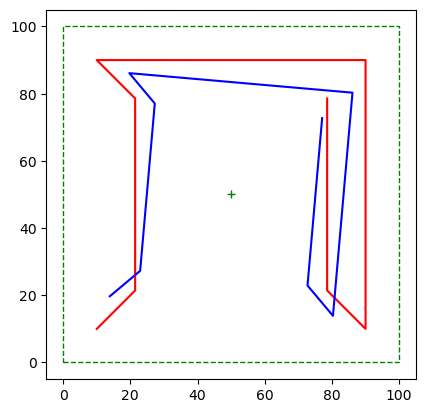


 residuals of camB relative to camA
[-3.8883 -1.4877 -5.8455 -9.6987  3.8883  9.6987  5.8455  1.4877 -9.6987
 -5.8455  1.4877  3.8883  9.6987 -3.8883 -1.4877  5.8455]
[[-3.8883 -1.4877 -5.8455 -9.6987  3.8883  9.6987  5.8455  1.4877]
 [-9.6987 -5.8455  1.4877  3.8883  9.6987 -3.8883 -1.4877  5.8455]]

 residuals of camA relative to camB
[ 3.8883  1.4877  5.8455  9.6987 -3.8883 -9.6987 -5.8455 -1.4877  9.6987
  5.8455 -1.4877 -3.8883 -9.6987  3.8883  1.4877 -5.8455]
[[ 3.8883  1.4877  5.8455  9.6987 -3.8883 -9.6987 -5.8455 -1.4877]
 [ 9.6987  5.8455 -1.4877 -3.8883 -9.6987  3.8883  1.4877 -5.8455]]


In [24]:
#
# Test the residual function to make sure it is doing the right thing.
#

# create two cameras with same intrinsic but slightly different extrinsic parameters
c = [50,50]
camA = Camera(f=200,c=np.array([c]).T,t=np.array([[0,0,0]]).T, R=makerotation(0,0,0))
camB = Camera(f=200,c=np.array([c]).T,t=np.array([[0,0,0]]).T, R=makerotation(0,0,0))

paramsA = np.array([0,0,0,0.5,0.5,-2.5])
paramsB = np.array([0,0,5,0.5,0.5,-3])
camA.update_extrinsics(paramsA)
camB.update_extrinsics(paramsB)

print(camA)
print(camB)

# create a test object (corners of a 3D cube) 
pts3 = np.array([[0,0,0],[0,0,1],[0,1,1],[0,1,0],[1,1,0],[1,0,0],[1,0,1],[1,1,1]]).T
print(pts3)
# visualize the two projections
pts2A = camA.project(pts3)
pts2B = camB.project(pts3)

plt.plot(pts2A[0,:],pts2A[1,:],'r')
plt.plot(pts2B[0,:],pts2B[1,:],'b')
#visualize the sensor frame assuming our sensor is centered around the principal point
plt.gca().add_patch(patches.Rectangle((0,0),2*c[0],2*c[1],color='g',fill=False,ls='--')) 
plt.plot(c[0],c[1],'g+')
plt.axis('square')
plt.show()

# double check that the residuals are the same as the difference in the reprojected coordinates
print("\n residuals of camB relative to camA")
print(residuals(pts3,pts2A,camB,paramsB))
print(pts2A-pts2B)

print("\n residuals of camA relative to camB")
print(residuals(pts3,pts2B,camA,paramsA))
print(pts2B-pts2A)


# 3. Camera Pose Estimation

We are now ready to estimate camera pose using optimize.  Implement a function **calibratePose** which takes as input the 3D coordinates of a calibration object, the observed 2D coordinates in the image, and an initial guess of the camera. Your function should use **scipy.optimize.leastsq** to optimize the extrinsic parameters in order to minimize the reprojection error. Since the **residuals** function takes additional arguments and **leastsq** expects a function which only takes the parameter vector as input, you should use Python's **lambda** function to wrap **residuals**, subistituting in the parameters that are fixed during the optimization. Once you have determined the optimum parameters, update the extrinsic parameters to the optimum and return the resulting camera.


## 3.1 Implementation [30pts]

In [46]:
def calibratePose(pts3,pts2,cam_init,params_init):
    """
    Calibrate the provided camera by updating R,t so that pts3 projects
    as close as possible to pts2

    Parameters
    ----------
    pts3 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (3,N)

    pts2 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (2,N)

    cam : Camera
        Initial estimate of camera
        
    params_init : 1D numpy.array (dtype=float)
        Initial estimate of camera extrinsic parameters ()
        params[0:3] are the rotation angles, params[3:6] are the translation

    Returns
    -------
    cam : Camera
        Refined estimate of camera with updated R,t parameters
        
    """

    # use scipy.optimize.leastsq to optimize for params and return the new camera ...
    new_cam = cam_init
    residuals_func = lambda params: residuals(pts3,pts2,new_cam,params)
    params_opt, _ = scipy.optimize.leastsq(residuals_func,params_init)
    new_cam.update_extrinsics(params_opt)
    return new_cam
    
    

# 3.2 Synthetic Test Example and Failure Cases [10pts]

Use the code below to check that your calibrate function works. Add some code to also visualize the point locations in 3D and the location and orientation of the camera (i.e., using the 3D plotting functions from Assignment 2)

Once you are confident that your calibration function is behaving correctly, you should experiment with changing the initial parameters.  Find a set of initial parameters which yields a ***wrong*** solution (i.e. where the Final Camera is not similar to the True Camera).  In the text box below indicate what bad initialization you used and the resulting set of camera parameters after the optimization. Give a brief explanation of where this bad camera is located and what direction it is oriented in.   


 True Camera
Camera : 
 f=50 
 c=[[50 50]] 
 R=[[ 1.      0.      0.    ]
 [ 0.      0.9848 -0.1736]
 [ 0.      0.1736  0.9848]] 
 t = [[-0.25 -0.25 -2.  ]]

 Initial Camera
Camera : 
 f=50 
 c=[[50 50]] 
 R=[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 
 t = [[ 0  0 -2]]

 Final Camera
[[56.0581 54.466  54.8774 56.8497 85.3654 82.036  71.6517 73.1383]
 [65.7563 63.3818 82.008  94.9017 95.1819 65.6476 63.2902 82.0743]]


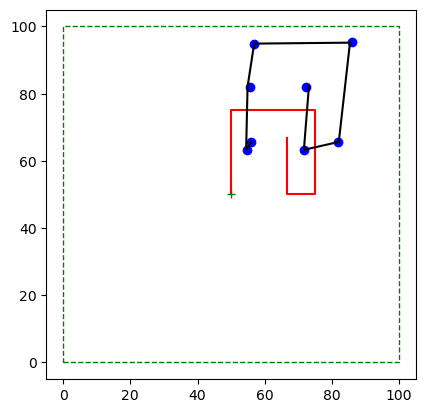

In [47]:
# 3D calibration object
pts3 = np.array([[0,0,0],[0,0,1],[0,1,1],[0,1,0],[1,1,0],[1,0,0],[1,0,1],[1,1,1]]).T

# true camera
c = [50,50]
cam_true = Camera(f=50,c=np.array([c]).T,t=np.array([[-0.25,-0.25,-2]]).T, R=makerotation(10,0,0))

print("\n True Camera")
print(cam_true)

# image of calibration object with some simulated noise in the 2D locations
pts2 = cam_true.project(pts3)
noiselevel = 0.5
pts2 = pts2 + noiselevel*np.random.randn(pts2.shape[0],pts2.shape[1])

# initial guess of camera params
cam = Camera(f=50,c=np.array([[50,50]]).T,t=np.array([[0,0,0]]).T, R=makerotation(0,0,0))
params_init = np.array([0,0,0,0,0,-2]) 
cam.update_extrinsics(params_init)

print("\n Initial Camera")
print(cam)
pts2init = cam.project(pts3)

# now run calibration
cam = calibratePose(pts3,pts2,cam,params_init)

print("\n Final Camera")
pts2final = cam.project(pts3)
print(pts2final)

#
# Plot the true, initial and final reprojections
# The final reprojection should be on top of the true image
#
plt.plot(pts2[0,:],pts2[1,:],'bo')
plt.plot(pts2init[0,:],pts2init[1,:],'r')
plt.plot(pts2final[0,:],pts2final[1,:],'k')
plt.gca().add_patch(patches.Rectangle((0,0),2*c[0],2*c[1],color='g',fill=False,ls='--')) 
plt.plot(c[0],c[1],'g+')
plt.axis('square')
plt.show()

#
# Add some additional visualiztion here to show the points in 3D and the locations and orientations
# of cam_true and cam.  You can either use a 3D plot or show multiple 2D plots (e.g. overhead
# and side views).  Play with this! Maybe try the visualization tools in Open3D if you want even more fun!
#



 True Camera
Camera : 
 f=50 
 c=[[50 50]] 
 R=[[ 1.      0.      0.    ]
 [ 0.      0.9848 -0.1736]
 [ 0.      0.1736  0.9848]] 
 t = [[-0.25 -0.25 -2.  ]]

 Initial Camera
Camera : 
 f=50 
 c=[[50 50]] 
 R=[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 
 t = [[ 1  2 -2]]

 Final Camera
Camera : 
 f=50 
 c=[[50 50]] 
 R=[[ 1.     -0.     -0.    ]
 [ 0.      0.9848 -0.1736]
 [ 0.      0.1736  0.9848]] 
 t = [[-0.25 -0.25 -2.  ]]


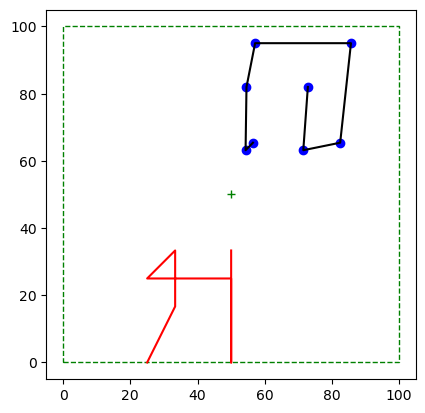

In [76]:
#
# Now repeat the calibration but with a setting for params_init that results
# in the optimization finding a poor solution (a bad local minima)
#

#
# Visualize the resulting bad solution.
#
# 3D calibration object
pts3 = np.array([[0,0,0],[0,0,1],[0,1,1],[0,1,0],[1,1,0],[1,0,0],[1,0,1],[1,1,1]]).T

# true camera
c = [50,50]
cam_true = Camera(f=50,c=np.array([c]).T,t=np.array([[-0.25,-0.25,-2]]).T, R=makerotation(10,0,0))

print("\n True Camera")
print(cam_true)

# image of calibration object with some simulated noise in the 2D locations
pts2 = cam_true.project(pts3)
noiselevel = 0
pts2 = pts2 + noiselevel*np.random.randn(pts2.shape[0],pts2.shape[1])

# initial guess of camera params
cam = Camera(f=50,c=np.array([[50,50]]).T,t=np.array([[0,0,0]]).T, R=makerotation(0,0,0))
params_init = np.array([0,0,0,1,2,-2]) 
cam.update_extrinsics(params_init)

print("\n Initial Camera")
print(cam)
pts2init = cam.project(pts3)

# now run calibration
cam = calibratePose(pts3,pts2,cam,params_init)

print("\n Final Camera")
print(cam)
pts2final = cam.project(pts3)

#
# Plot the true, initial and final reprojections
# The final reprojection should be on top of the true image
#
plt.plot(pts2[0,:],pts2[1,:],'bo')
plt.plot(pts2init[0,:],pts2init[1,:],'r')
plt.plot(pts2final[0,:],pts2final[1,:],'k')
plt.gca().add_patch(patches.Rectangle((0,0),2*c[0],2*c[1],color='g',fill=False,ls='--')) 
plt.plot(c[0],c[1],'g+')
plt.axis('square')
plt.show()

#
# Add some additional visualiztion here to show the points in 3D and the locations and orientations
# of cam_true and cam.  You can either use a 3D plot or show multiple 2D plots (e.g. overhead
# and side views).  Play with this! Maybe try the visualization tools in Open3D if you want even more fun!
#

# .....

## Explain one of the failures including where the initial camera was that led to failure.

One of the failures was when the initial camera was located at (1,2,-2) and had a rotation of (0,0,0). This led to a failure because the initial camera was located behind the calibration object and was facing the opposite direction of the calibration object. This led to a failure because the camera was not able to see the calibration object and thus could not optimize the extrinsic parameters to minimize the reprojection error.